In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer
import math
# Disable gradient calculations
from functools import partial
torch.set_grad_enabled(False)

In [2]:
hooked_model = HookedTransformer.from_pretrained('gpt2-xl', device='cuda:1')

Loaded pretrained model gpt2-xl into HookedTransformer


In [3]:
@torch.no_grad()
def vector_moments(values, dim=1):
    mean = torch.mean(values, dim=dim)
    diffs = values - mean[:, None]
    var = torch.mean(torch.pow(diffs, 2.0), dim=dim)
    std = torch.pow(var, 0.5)
    zscore = diffs / std[:, None]
    skew = torch.mean(torch.pow(zscore, 3.0), dim=dim)
    kurt = torch.mean(torch.pow(zscore, 4.0), dim=dim)
    return mean, var, skew, kurt

@torch.no_grad()
def neuron_vocab_cosine_moments(model):
    # runs computation on whatever device model is loaded on (recommended to use mps if available)
    n_layers, d_mlp, d_vocab = model.W_out.shape[0], model.W_U.shape[1], model.W_out.shape[1]
    means, variances, skews, kurtoses = [], [], [], []

    W_U = model.W_U / model.W_U.norm(dim=0, keepdim=True)

    for i in range(n_layers):
        w_out = model.W_out[i]

        direct = w_out @ W_U
        direct = direct / w_out.norm(dim=1)[:, None]

        mean, var, skew, kurt = vector_moments(direct)

        means.append(mean)
        variances.append(var)
        skews.append(skew)
        kurtoses.append(kurt)

    # Flatten the list of numpy arrays.
    means = torch.stack(means).flatten().cpu().numpy()
    variances = torch.stack(variances, dim=0).flatten().cpu().numpy()
    skews = torch.stack(skews, dim=0).flatten().cpu().numpy()
    kurtoses = torch.stack(kurtoses, dim=0).flatten().cpu().numpy()

    n_layers, d_mlp, _ = model.W_out.shape

    neuron_moments_df = pd.DataFrame({
        'vocab_mean': means,
        'vocab_var': variances,
        'vocab_skew': skews,
        'vocab_kurt': kurtoses
    }, index=pd.MultiIndex.from_product([range(n_layers), range(d_mlp)]))
    neuron_moments_df.index.names = ['layer', 'neuron']

    return neuron_moments_df

data = neuron_vocab_cosine_moments(hooked_model)



In [4]:
def make_composition_dict(model, neuron_df, use_cos=True):
    if use_cos:
        W_U = model.W_U / model.W_U.norm(dim=0, keepdim=True)
    else:
        W_U = model.W_U
    neuron_col = 'neuron_ix' if 'neuron_ix' in neuron_df.columns else 'neuron'
    composition_dict = {}
    for ix, (layer, neuron) in enumerate(neuron_df[['layer', neuron_col]].values):
        if ix % 100 == 0:
            # print(f'{ix} | layer {layer} | neuron {neuron}')
            pass
        w_out = model.W_out[layer, neuron]
        if use_cos:
            w_out = w_out / w_out.norm(dim=0, keepdim=True)
        vocab_dist = (w_out @ W_U).cpu().numpy()
        composition_dict[layer, neuron] = vocab_dist
    return composition_dict

In [5]:

# symbolic token, numeric token, alpha token


TYPE_FEATURES = {
    'all_white_space': lambda x: x.strip() == '',
    'all_caps': lambda x: x.strip().isupper() and len(x.strip()) > 1,
    'all_lower': lambda x: x.strip().islower(),
    'all_alpha': lambda x: x.strip().isalpha(),
    'all_numeric': lambda x: x.strip().isdecimal(),
    'all_symbolic': lambda x: any(not c.isalnum() for c in x.strip())
}

SYMBOL_FEATURES = {
    'contains_period': lambda x: '.' in x,
    'contains_comma': lambda x: ',' in x,
    'contains_exclamation': lambda x: '!' in x,
    'contains_question': lambda x: '?' in x,
    'contains_semicolon': lambda x: ';' in x,
    'contains_colon': lambda x: ':' in x,
    'contains_dash': lambda x: '-' in x,
    'contains_slash': lambda x: '/' in x,
    'contains_backslash': lambda x: '\\' in x,
    'contains_underscore': lambda x: '_' in x,
    'contains_carrot': lambda x: '^' in x,
    'contains_apostrophe': lambda x: '\'' in x,
    'contains_quotation': lambda x: '\"' in x,
    'contains_close_paren': lambda x: ')' in x,
    'contains_open_paren': lambda x: '(' in x,
    'contains_close_bracket': lambda x: ']' in x,
    'contains_open_bracket': lambda x: '[' in x,
    'contains_close_brace': lambda x: '}' in x,
    'contains_open_brace': lambda x: '{' in x,
    'contains_closing_punc': lambda x: any([c in x for c in [')', ']', '}', '>']]),
    'contains_opening_punc': lambda x: any([c in x for c in ['(', '[', '{', '<']]),
    'contains_math_symbol': lambda x: any([c in x for c in ['+', '-', '*', '/', '=', '<', '>']]),
    'contains_currency': lambda x: any([c in x for c in ['$', '€', '£', '¥']]),
    'contains_dollar': lambda x: '$' in x,
    'contains_double_dollar': lambda x: '$$' in x,
}

NUMBER_WORDS = set([
    'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
    'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen',
    'seventeen', 'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty',
    'sixty', 'seventy', 'eighty', 'ninety', 'hundred', 'thousand', 'million',
    'billion', 'trillion', 'quadrillion', 'quintillion', 'sextillion',
    'hundreds', 'thousands', 'millions', 'billions', 'trillions', 'dozen', 'dozens'
])

IS_QUANITY_WORD = None  # TODO

NUMERIC_FEATURES = {
    'contains_digit': lambda x: any([c.isdigit() for c in x]),
    'all_digits': lambda x: all([c.isdigit() for c in x.strip()]),
    'is_number_word': lambda x: x.strip() in NUMBER_WORDS,
    'is_year': lambda x: x.strip().isdecimal() and int(x.strip()) > 1490 and int(x.strip()) < 2200,
    'integral_value': lambda x: int(x.strip()) if x.strip().isdecimal() else np.nan,
    'is_one_digit': lambda x: x.strip().isdecimal() and len(x.strip()) == 1,
    'is_two_digit': lambda x: x.strip().isdecimal() and len(x.strip()) == 2,
    'is_three_digit': lambda x: x.strip().isdecimal() and len(x.strip()) == 3,
    'is_four_digit': lambda x: x.strip().isdecimal() and len(x.strip()) == 4,
    'is_lt_31': lambda x: x.strip().isdecimal() and int(x.strip()) <= 31,
}

PRONOUN_FEATURES = {
    'is_male_pronoun': lambda x: x.strip().lower() in set(['he', 'him', 'his', 'himself']),
    'is_female_pronoun': lambda x: x.strip().lower() in set(['she', 'her', 'hers', 'herself']),
    'is_neutral_pronoun': lambda x: x.strip().lower() in set(['they', 'them', 'their', 'theirs', 'themself', 'themselves']),
    'is_first_person_pronoun': lambda x: x.strip().lower() in set(['i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves']),
    'is_second_person_pronoun': lambda x: x.strip().lower() in set(['you', 'your', 'yours', 'yourself', 'yourselves']),
    'is_third_person_pronoun': lambda x: x.strip().lower() in set(['he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'they', 'them', 'their', 'theirs', 'themself', 'themselves']),
    'is_plural_pronoun': lambda x: x.strip().lower() in set(['we', 'us', 'our', 'ours', 'ourselves', 'they', 'them', 'their', 'theirs', 'themself', 'themselves']),
    'is_singular_pronoun': lambda x: x.strip().lower() in set(['i', 'me', 'my', 'mine', 'myself', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself']),
    'is_subject_pronoun': lambda x: x.strip().lower() in set(['i', 'we', 'you', 'he', 'she', 'it', 'they']),
    'is_object_pronoun': lambda x: x.strip().lower() in set(['me', 'us', 'you', 'him', 'her', 'it', 'them']),
    'is_possessive_pronoun': lambda x: x.strip().lower() in set(['my', 'mine', 'our', 'ours', 'your', 'yours', 'his', 'her', 'hers', 'its', 'their', 'theirs']),
    'is_reflexive_pronoun': lambda x: x.strip().lower() in set(['myself', 'ourselves', 'yourself', 'yourselves', 'himself', 'herself', 'itself', 'themselves']),
    'is_personal_pronoun': lambda x: x.strip().lower() in set(['i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'they', 'them', 'their', 'theirs', 'themself', 'themselves']),
    'is_indefinite_pronoun': lambda x: x.strip().lower() in set(['anybody', 'anyone', 'anything', 'each', 'either', 'everybody', 'everyone', 'everything', 'neither', 'nobody', 'no one', 'nothing', 'one', 'somebody', 'someone', 'something', 'both', 'few', 'many', 'several', 'all', 'any', 'most', 'none', 'some', 'such']),
    'is_demonstrative_pronoun': lambda x: x.strip().lower() in set(['this', 'that', 'these', 'those']),
    'is_interrogative_pronoun': lambda x: x.strip().lower() in set(['who', 'whom', 'whose', 'which', 'what']),
    'is_relative_pronoun': lambda x: x.strip().lower() in set(['who', 'whom', 'whose', 'which', 'that']),
    'is_intensive_pronoun': lambda x: x.strip().lower() in set(['myself', 'yourself', 'himself', 'herself', 'itself', 'ourselves', 'yourselves', 'themselves']),
    'is_nonreflexive_pronoun': lambda x: x.strip().lower() in set(['i', 'me', 'we', 'us', 'you', 'he', 'him', 'she', 'her', 'it', 'they', 'them']),
}

STARTS_FEATURES = {
    'starts_w_vowel': lambda x: x.strip().lower().startswith(tuple(['a', 'e', 'i', 'o', 'u'])),
    'starts_w_consonant': lambda x: x.strip().lower().isalpha() and not x.strip().lower().startswith(tuple(['a', 'e', 'i', 'o', 'u'])),
    'start_w_no_space': lambda x: len(x) > 0 and x[0] != ' ',
    'start_w_no_space_and_letter': lambda x: len(x) > 0 and x[0].isalpha(),
    'start_w_no_space_and_digit': lambda x: len(x) > 0 and x[0].isdigit(),
    'starts_w_digit': lambda x: x.strip().isdecimal() and len(x.strip()) > 0,
    'starts_w_space': lambda x: x[0] == ' ' if len(x.strip()) > 0 else False,
    'start_w_space_and_letter': lambda x: len(x) > 1 and x[0] == ' ' and x[1].isalpha(),
    'starts_w_cap': lambda x: x.strip()[0].isupper() if len(x.strip()) > 0 else False,
    'starts_w_no_space_and_cap': lambda x: x[0].isupper() if len(x.strip()) > 0 else False,
    'starts_w_no_space_and_lower': lambda x: x[0].islower() if len(x.strip()) > 0 else False,
}


def suffix_features(x, suffix):
    return x.strip().lower().endswith(suffix)


# SUFFIX/PREFIX FEATURES
SUFFIXES = [
    "ness", "ment", "tion", "sion", "ance", "ence", "er", "or", "ist", "ism",
    "hood", "ship", "age", "able", "ible", "al", "ial", "ish", "ive", "less",
    "ful", "ous", "ic", "ly", "ward", "wise", "ize", "ise", "en", "ify", "let",
    "ling", "ie", "ette", "dom", "logy", "graphy", "phobia", "y", "cy", "ty",
    "ant", "ent", "ary", "ery", "ing", "ed", "s", "est"
]

SUFFIX_FEATURES = {
    f'end_w_{suffix}': partial(suffix_features, suffix=suffix)
    for suffix in SUFFIXES
}


def prefix_features(x, prefix):
    return x.strip().lower().startswith(prefix)


PREFIXES = ["un", "re", "in", "im", "dis", "en", "em", "non", "over", "mis", "sub", "pre", "inter", "fore", "de", "trans", "super", "semi", "anti", "mid", "under", "mono", "bi", "tri", "multi", "poly", "ex", "micro", "macro",
            "auto", "tele", "homo", "hetero", "post", "geo", "aero", "hydro", "thermo", "electro", "photo", "pan", "micro", "mega", "kilo", "pseudo", "neo", "anti", "counter", "ultra", "infra", "circum", "peri", "hemi", "ped", "pod", "bio",
            "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
            ]

PREFIX_FEATURES = {
    f'start_w_{prefix}': partial(prefix_features, prefix=prefix)
    for prefix in PREFIXES
}

# is_month
MONTH_WORDS = set([
    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august',
    'september', 'october', 'november', 'december',
    'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept', 'oct', 'nov', 'dec',
])

# is_day of week
DAY_OF_WEEK_WORDS = set([
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
    'mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun',
])

# is_state
STATE_WORDS = set([
    'alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado',
    'connecticut', 'delaware', 'florida', 'georgia', 'hawaii', 'idaho',
    'illinois', 'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana',
    'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota',
    'mississippi', 'missouri', 'montana', 'nebraska', 'nevada',
    'hampshire', 'jersey', 'mexico', 'york',
    'carolina', 'dakota', 'ohio', 'oklahoma', 'oregon',
    'pennsylvania', 'rhode',
    'tennessee', 'texas', 'utah', 'vermont', 'virginia', 'washington',
    'west virginia', 'wisconsin', 'wyoming',
])

STATE_ABV_WORDS = set([
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY',
])

WEBSITE_SUFFIXES = set([
    'com', 'net', 'org', 'edu', 'gov', 'mil', 'int', 'io', 'co', 'uk', 'ca', 'ai'
])

CONTRASTIVE_CONJUNCTIONS = set([
    'but', 'however', 'nonetheless', 'yet', 'nevertheless', 'although'
])

# is_country

# is_name

# measurement units
LENGTH_WORDS = set([
    'meter', 'metre', 'inch', 'foot', 'feet', 'yard', 'mile'
])

TIME_WORDS = set([
    'second', 'minute', 'hour', 'day', 'week', 'month', 'year'
])


WORD_GROUP_FEATURES = {
    'is_month': lambda x: x.strip().lower() in MONTH_WORDS,
    'is_day_of_week': lambda x: x.strip().lower() in DAY_OF_WEEK_WORDS,
    'is_state': lambda x: x.strip().lower() in STATE_WORDS,
    'is_state_abv': lambda x: x.strip() in STATE_ABV_WORDS,
    'is_website_suffix': lambda x: x in WEBSITE_SUFFIXES,
    'is_length': lambda x: any([word in x.strip().lower() for word in LENGTH_WORDS]),
    'is_time': lambda x: any([word in x.strip().lower() for word in TIME_WORDS]),
    'is_contrastive_conjuction': lambda x: x.strip().lower() in CONTRASTIVE_CONJUNCTIONS,
}


ALL_FEATURES = {
    **TYPE_FEATURES,
    **SYMBOL_FEATURES,
    **NUMERIC_FEATURES,
    **PRONOUN_FEATURES,
    **STARTS_FEATURES,
    **SUFFIX_FEATURES,
    **PREFIX_FEATURES,
    **WORD_GROUP_FEATURES,
}

In [6]:
def make_vocab_df(model, small_norm_threshold=0.52):
    decoded_vocab = {
        tix: model.tokenizer.decode(tix)
        for tix in model.tokenizer.get_vocab().values()
    }

    vocab_df = pd.DataFrame({'token_string': decoded_vocab})
    for feature_name, feature_fn in ALL_FEATURES.items():
        vocab_df[feature_name] = vocab_df['token_string'].apply(feature_fn)

    vocab_df['unembed_norm'] = model.W_U.norm(
        dim=0).cpu().numpy()[:len(vocab_df)]
    vocab_df['embed_norm'] = model.W_E.norm(
        dim=1).cpu().numpy()[:len(vocab_df)]

    vocab_df['small_norm'] = vocab_df['embed_norm'] < small_norm_threshold

    empty_cols = vocab_df.sum(axis=0) == 0
    # drop columns that are all zero
    vocab_df = vocab_df.drop(columns=empty_cols[empty_cols].index)

    return vocab_df.copy()

In [7]:
vocab_df = make_vocab_df(hooked_model)
vocab_df = vocab_df.sort_index()

/tmp/ipykernel_1634731/695539029.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vocab_df[feature_name] = vocab_df['token_string'].apply(feature_fn)
/tmp/ipykernel_1634731/695539029.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vocab_df[feature_name] = vocab_df['token_string'].apply(feature_fn)
/tmp/ipykernel_1634731/695539029.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

# Rest of the code

In [8]:
high_kurtosis_df = data.query('vocab_kurt > 10').reset_index()
high_var_df = data.query('vocab_var > 0.005').reset_index()
is_pred = data.query('vocab_kurt > 10 & vocab_skew > 0').reset_index()
high_kurtosis_composition_dict = make_composition_dict(hooked_model, high_kurtosis_df, use_cos=False)
high_var_composition_dict = make_composition_dict(hooked_model, high_var_df, use_cos=False)

In [9]:
# create set of keys of both dict 
high_kurtosis_keys = set(high_kurtosis_composition_dict.keys())
high_var_keys = set(high_var_composition_dict.keys())
#add two sets 
all_keys = high_kurtosis_keys.union(high_var_keys)


In [10]:
features = ["is_reflexive_pronoun",
    "is_second_person_pronoun",
    "is_female_pronoun",
    "is_neutral_pronoun",
    "is_male_pronoun",
    "contains_question",
    "is_one_digit",
    "contains_exclamation",
    "is_contrastive_conjuction",
    "is_relative_pronoun",
    "contains_apostrophe",
    "is_year",
    "contains_digit",
    "contains_close_paren",
    "contains_quotation",
    "is_month",
    "contains_semicolon",
    "contains_open_bracket",
    "contains_open_paren",
    "is_demonstrative_pronoun",
    "contains_currency",
    "contains_colon",
    "is_state",
    "is_possessive_pronoun",
    "contains_exclamation",
    "starts_w_cap",
    "all_caps",
    "start_w_no_space",
    "end_w_ed",
    "end_w_ing"]

In [11]:

def find_prediction_neurons(top_pred_neurons, top_pred_neuron_class, composition_dict, vocab_df, n_cols=5):


    vals=[]
    for ix, ((layer, neuron_ix), class_label) in enumerate(zip(top_pred_neurons, top_pred_neuron_class)):

        comp_scores = composition_dict[layer, neuron_ix]
        #True###
        true = comp_scores[vocab_df[class_label]].mean()

        #


        #False###
        false = comp_scores[~vocab_df[class_label]].mean()

        diff = np.abs(true - false)
        vals.append((layer, neuron_ix, class_label, true, false, diff))
    save_df = pd.DataFrame(vals, columns=['layer', 'neuron', 'feature', 'true', 'false', 'diff'])
    return save_df


In [12]:
def format_subplot(ax, grid_x=True):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if grid_x:
        ax.grid(linestyle='--', alpha=0.4)
    else:
        ax.grid(axis='y', linestyle='--', alpha=0.4)

In [13]:

def plot_prediction_neurons(top_pred_neurons, top_pred_neuron_class, composition_dict, vocab_df, n_cols=6):
    n_rows = math.ceil(len(top_pred_neurons) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    for ix, ((layer, neuron_ix), class_label) in enumerate(zip(top_pred_neurons, top_pred_neuron_class)):
        ax = axs[ix // n_cols, ix % n_cols]
        comp_scores = composition_dict[layer, neuron_ix]
        bin_range = np.min(comp_scores), np.max(comp_scores)
        ax.hist(comp_scores[vocab_df[class_label]], bins=100,
                log=True, range=bin_range, label='True', alpha=0.5)
        ax.hist(comp_scores[~vocab_df[class_label]], bins=100,
                log=True, range=bin_range, label='False', alpha=0.5)
        ax.set_title(f'L{layer}.{neuron_ix}')
        ax.legend(title=class_label)

        ax.grid(alpha=0.25, linestyle='--')

        if ix % n_cols == 0:
            ax.set_ylabel('token count')

        if ix // n_cols == n_rows - 1:
            ax.set_xlabel('$W_U \cdot w_{out}$')

    plt.tight_layout()
    #save 
    
    plt.savefig(f"plot_{class_label}.png")


In [ ]:
del hooked_model
torch.cuda.empty_cache()

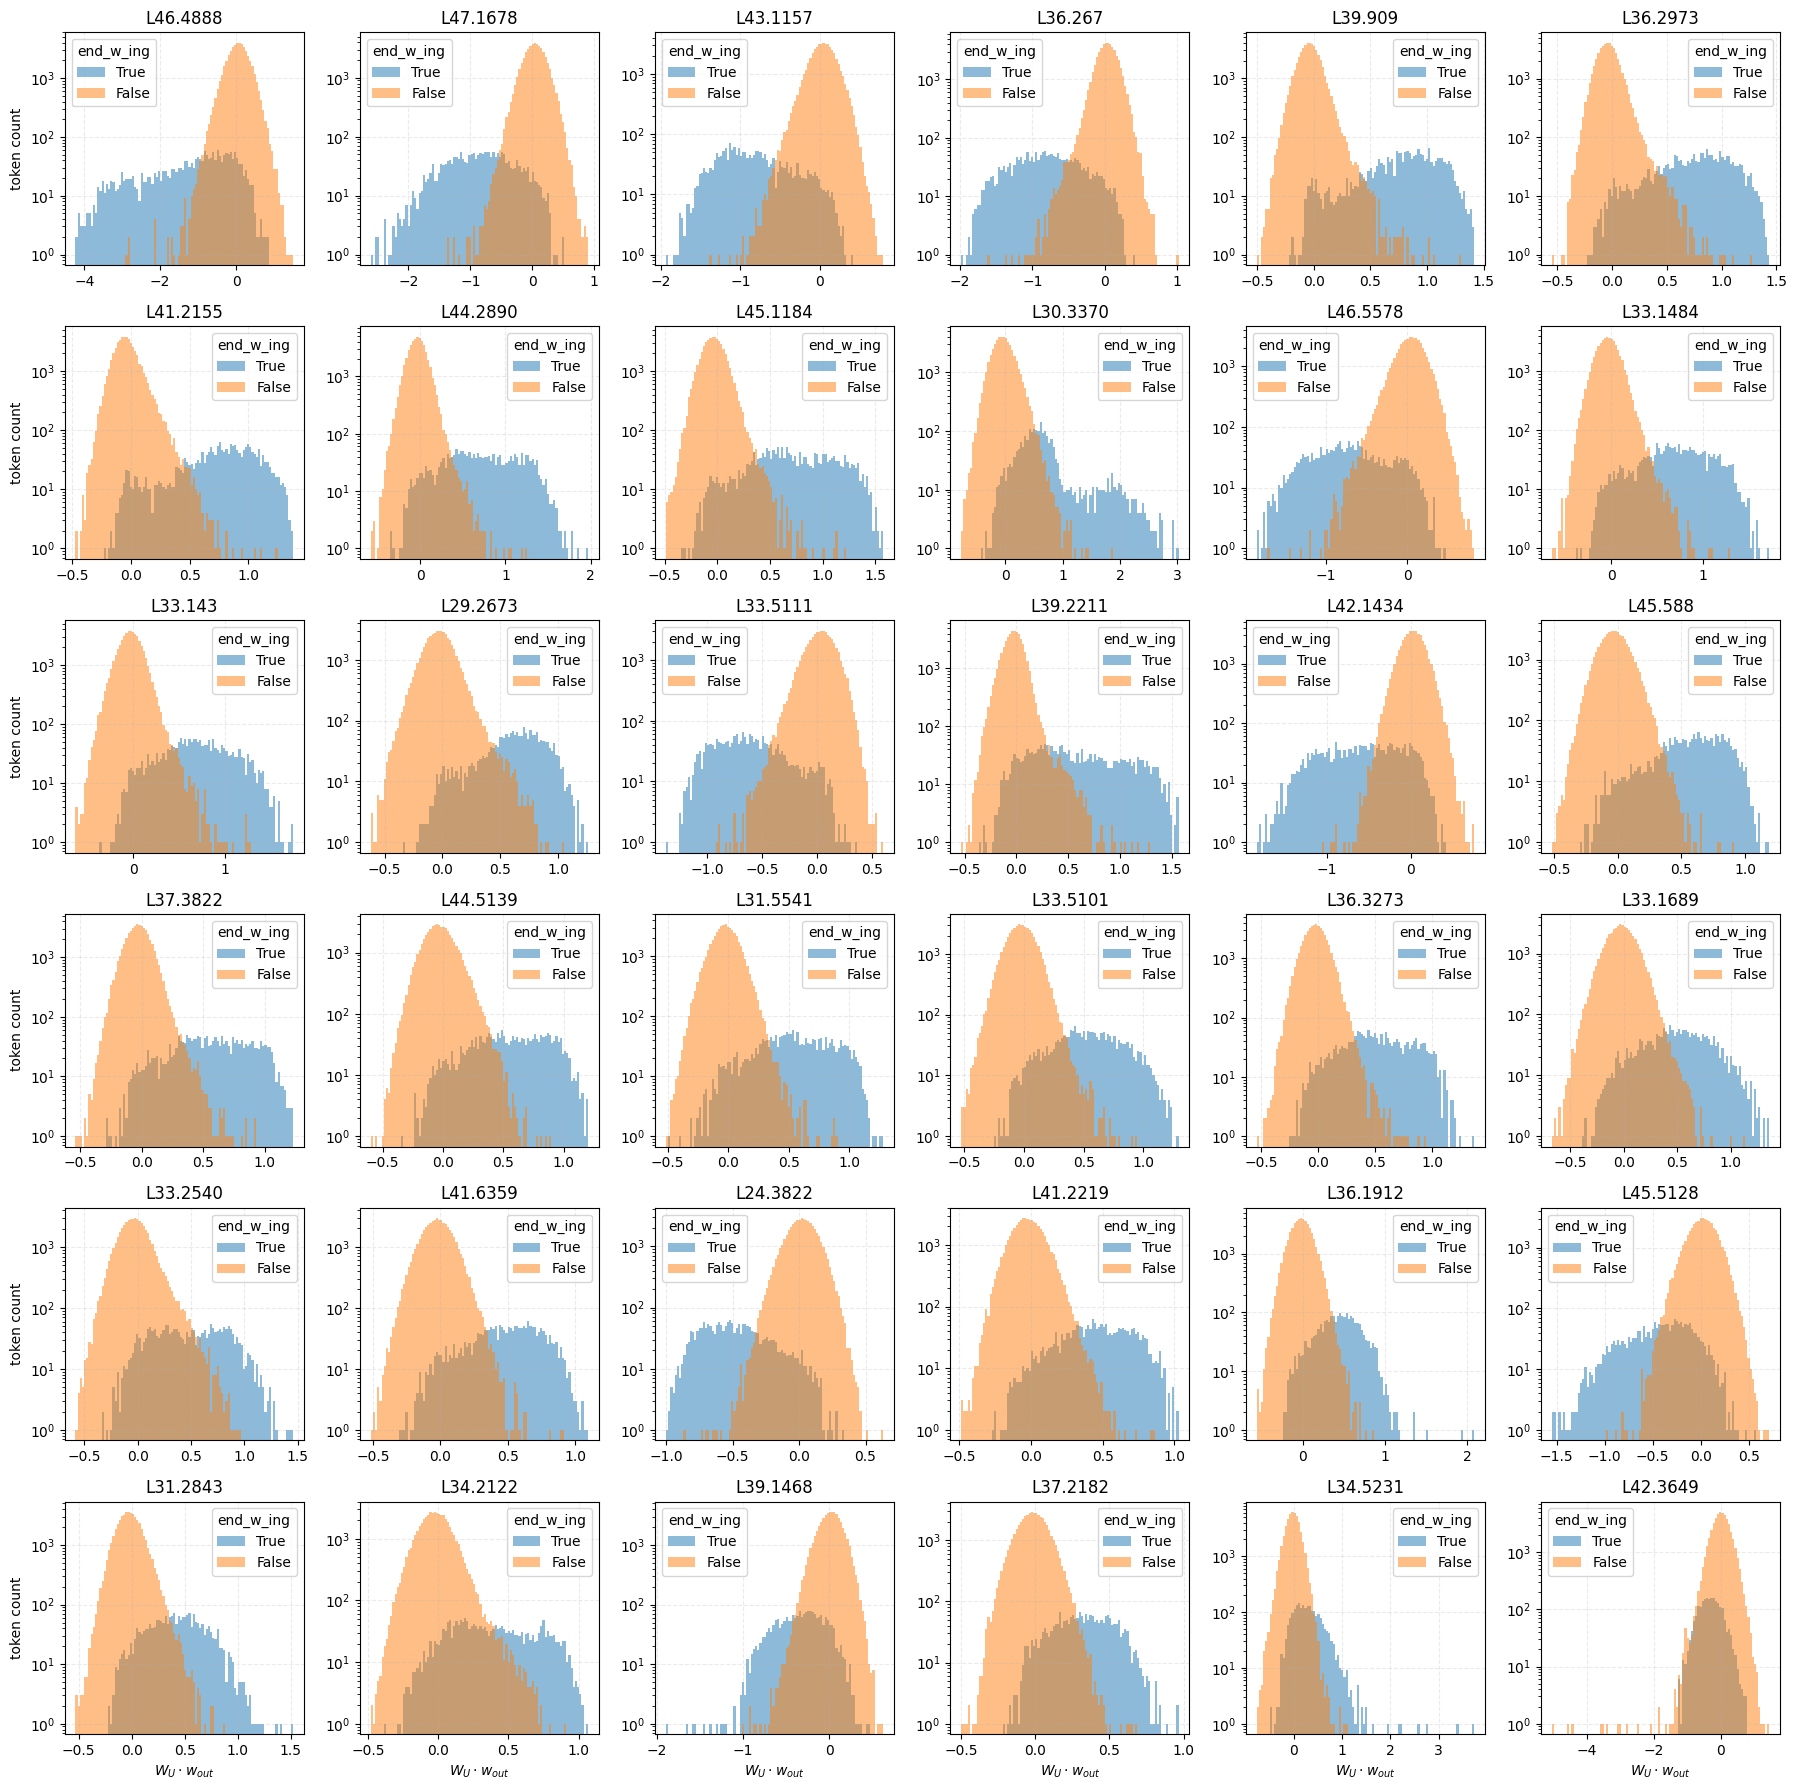

In [14]:
# for feature in features:
feature = "end_w_ing"
plot_neurons = [(k,feature) for k in all_keys]
top_pred_neurons = [n for n, c in plot_neurons]
top_pred_neuron_class = [c for n, c in plot_neurons]

vals = find_prediction_neurons(top_pred_neurons, top_pred_neuron_class, {**high_kurtosis_composition_dict, **high_var_composition_dict}, vocab_df)
vals = vals.sort_values(by='diff', ascending=False)
plot_neurons = [((row.layer, row.neuron),row.feature) for row in vals.head(36).itertuples()]
top_pred_neurons = [n for n, c in plot_neurons]
top_pred_neuron_class = [c for n, c in plot_neurons]
plot_prediction_neurons(top_pred_neurons, top_pred_neuron_class, {**high_kurtosis_composition_dict, **high_var_composition_dict}, vocab_df)

In [15]:
is_pred["layer"], is_pred["neuron"]
#make keys for is pred 
is_pred_keys = set(zip(is_pred["layer"], is_pred["neuron"]))

In [16]:
important_neurons = [(row.layer, row.neuron) for row in vals.head(32).itertuples()]
#see if important neurons are in is_pred
is_pred = [n in is_pred_keys for n in important_neurons ]

In [17]:
def format_subplot(ax, grid_x=True):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if grid_x:
        ax.grid(linestyle='--', alpha=0.4)
    else:
        ax.grid(axis='y', linestyle='--', alpha=0.4)

# VERTICAL

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import math


def plot_prediction_neurons(top_pred_neurons, top_pred_neuron_class, composition_dict, vocab_df, n_cols=1):
    n_rows = math.ceil(len(top_pred_neurons) / n_cols)

    fig, axs = plt.subplots(n_cols,n_rows, figsize=(n_rows * 3,n_cols * 3, ))

    # Ensure axs is always a 2D array
    if n_rows == 1:
        axs = np.expand_dims(axs, axis=0)
    if n_cols == 1:
        axs = np.expand_dims(axs, axis=1)

    for ix, ((layer, neuron_ix), class_label) in enumerate(zip(top_pred_neurons, top_pred_neuron_class)):
        ax = axs[ix // n_cols, ix % n_cols]
        comp_scores = composition_dict[layer, neuron_ix]
        bin_range = np.min(comp_scores), np.max(comp_scores)
        ax.hist(comp_scores[vocab_df[class_label]], bins=40,
                log=True, range=bin_range, label='True', alpha=0.5)
        ax.hist(comp_scores[~vocab_df[class_label]], bins=40,
                log=True, range=bin_range, label='False', alpha=0.5)
        ax.set_title(f'L{layer}.{neuron_ix}')
        #set x axis as negatie of max range to max range
        max_val = np.max(np.concatenate((np.abs(comp_scores[~vocab_df[class_label]]), np.abs(comp_scores[vocab_df[class_label]]))))
        ax.set_xlim(-max_val-0.05, max_val+0.05)
        ax.legend(title=class_label)

        ax.grid(alpha=0.25, linestyle='--')

        if ix % n_rows == 0:
            ax.set_ylabel('token count')

        if ix // n_rows == n_cols - 1:
            ax.set_xlabel('$W_U \cdot w_{out}$')

    plt.tight_layout()
    # Save the plot with the class label
    for ax in axs.flatten():
        format_subplot(ax, grid_x=False)
    plt.savefig(f"plot_{top_pred_neuron_class[0]}_ver.pdf", bbox_inches='tight')


In [34]:
# These are the first prediction and suppression neurons
all_keys = {(46, 4888),  (39, 909)}

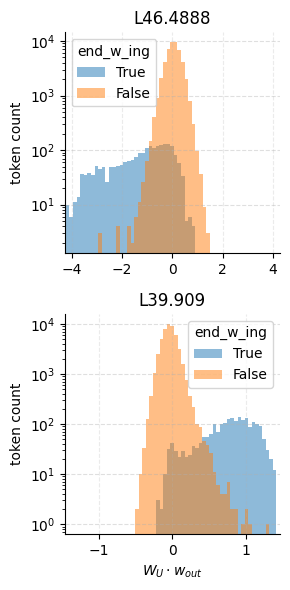

In [35]:
# for feature in features:
feature = "end_w_ing"
plot_neurons = [(k,feature) for k in all_keys]
top_pred_neurons = [n for n, c in plot_neurons]
top_pred_neuron_class = [c for n, c in plot_neurons]

vals = find_prediction_neurons(top_pred_neurons, top_pred_neuron_class, {**high_kurtosis_composition_dict, **high_var_composition_dict}, vocab_df)
vals = vals.sort_values(by='diff', ascending=False)
plot_neurons = [((row.layer, row.neuron),row.feature) for row in vals.head(2).itertuples()]
top_pred_neurons = [n for n, c in plot_neurons]
top_pred_neuron_class = [c for n, c in plot_neurons]
plot_prediction_neurons(top_pred_neurons, top_pred_neuron_class, {**high_kurtosis_composition_dict, **high_var_composition_dict}, vocab_df, n_cols=2)